# <center>Проект: предсказание токсичности соединений</center>

**<u>Дано:</u>**

* `train.csv` – данные для обучения
* `test_only_smiles.csv` – данные для предсказания

**<u>Необходимо:</u>**

1) Проанализировать данные + визуализация
2) Предобработать данные, чтобы улучшить качество модели
3) Обучить модель и провалидировать ее (метрика: *RMSE*)
4) Проверить модель на *test* данных и прислать результаты вместе с ноутбуком

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
# Ознакомимся с датасетом
train.head()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


In [4]:
# Посмотрим информацию о датасете
train.info()

# И описательную статистику
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


,activity
count,759.000000
mean,40.691304
std,36.150662
min,-38.300000
25%,10.750000
50%,30.100000
75%,69.550000
max,111.000000


In [5]:
# Избавимся от дубликатов
train_copy = train.copy()
train_copy.drop_duplicates()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2
...,...,...
754,CC1=CC2=CC=CN=C2C=C1,43.1
755,C12CC[C@@](O)(C#C)[C@@]1(C)CCC3C4CCC(=O)C=C4CCC23,15.8
756,CCCCNS(=O)(=O)C1=CC=CC=C1,17.8
757,NC1=C(Cl)C(Cl)=NC(C(O)=O)=C1Cl,55.1


В нашем датасете всего два столбца:
1) Категориальный признак `SMILES` (тип *object*), содержащий химическую формулу, записанную в текстовом формате.
2) Наш *target* `activity` (тип *float64*), токсичность вещества, которая варьирует от $-38.3$ до $111.0$ в процентах. 

Пропусков и дубликатов в датасете нет.

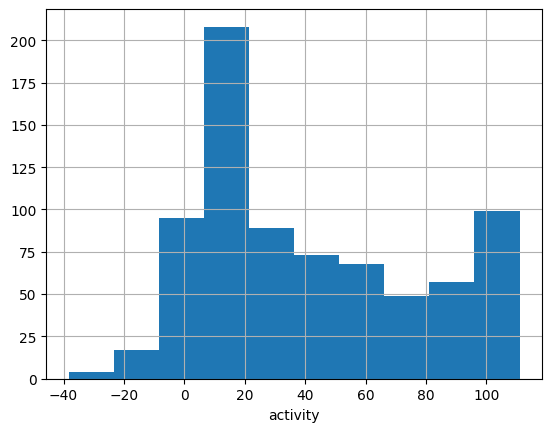

In [6]:
import matplotlib.pyplot as plt

# Визуализация значений 'activity' 
train['activity'].hist()
plt.xlabel('activity')
plt.show()

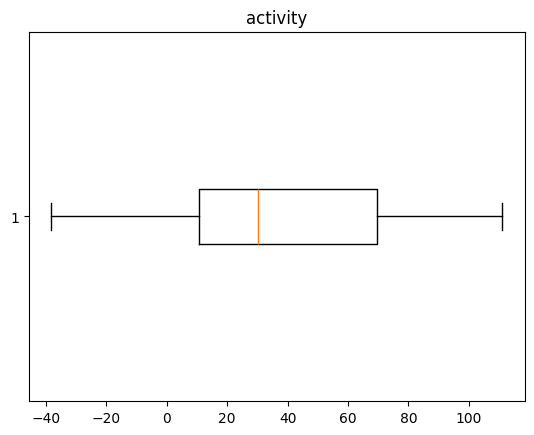

In [7]:
# Boxplot для 'activity'
plt.boxplot(train['activity'], vert=False)
plt.title('activity')
plt.show()

Визуализация подтверждает информацию, которую мы получили ранее:

* Значения варьируют от $-38.3$ до $111.0$;
* Медиана $30.1$.


Также на *BoxPlot* видно, что нет выбросов.

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [9]:
# Один из способов превратить молекулы в числа – это fingerprints
# Функция из ноутбука
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

In [10]:
x = smiles_to_fp(train.SMILES)

[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerator
[19:29:00] DEPRECATION WARNING: please use MorganGenerat

In [11]:
# Химические формулы были перекодированы в векторы одинаковой длины
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
# Кол-во признаков из-за этого сильно увеличилось
x.shape

(759, 1024)

Для нашей задачи первое, что приходит в голову - это обучить модель линейной регрессии. Посмотрим как она справится с нашими "сырыми" данными.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x, train['activity'], test_size=0.2, random_state=42)
print('Train:', x_train.shape, y_train.shape)
print('Test:', x_valid.shape, y_valid.shape)

Train: (607, 1024) (607,)
Test: (152, 1024) (152,)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [16]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
# Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(x_train)
# Делаем предсказание для валидационной выборки
y_valid_predict = lr_model.predict(x_valid)
# В условии сказано использовать для оценки  модели RMSE
print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

Train RMSE: 4.645
Valid RMSE: 1495688057864.612


*RMSE* измеряется в тех же единицах измерения, что и целевая переменная, и чем она меньше, тем лучше. В нашем датасете токсичность вещества измеряется в процентах, если я правильно понял ответы на вопросы нашего ментора Татьяны. Следовательно: на тренировочной выборке *RMSE* $4.6\%$ (вроде бы неплохо), а вот на валидационной какие-то запредельные цифры. Будто бы очень сильное переобучение, раз модель не смогла подстроиться под валидационную выборку. А раз качетсво модели всегда оценивается по валидационной (тестовой) выборке, значит есть к чему стремиться.

Попробуем понизить размерность признаков при помощи *PCA (Principal Components Analysis / Метод главных компонент)*, один из базовых способов уменьшения размерности. Для уменьшения размерности метод главных компонент проводит линейное преобразование пространства, которое сохраняет длины векторов. Таким образом происходит отображение признаков в новое пространство с меньшей размерностью. Нам это вроде бы подходит.


Напишим функцию, которая будет понижать размерность при помощи *PCA*. И попробуем подобрать оптимальное кол-во `n_components`.

In [17]:
from sklearn.decomposition import PCA

In [18]:
def use_pca(x_train, x_valid, n):
    pca = PCA(n_components=n, random_state=42)
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_valid = pca.transform(x_valid)
    
    return pca_x_train, pca_x_valid

In [19]:
# Также обернём создание модели линейной ререссии в функцию, для удобства
def use_linreg(x_train, x_valid, y_train, y_valid):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    y_train_predict = lr_model.predict(x_train)
    y_valid_predict = lr_model.predict(x_valid)
    
    print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
    print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

In [20]:
numbers = (8, 16, 32, 64, 128, 256)
for n in numbers:
    print(f'n_components={n}')
    pca_x_train, pca_x_valid = use_pca(x_train, x_valid, n)
    use_linreg(pca_x_train, pca_x_valid, y_train, y_valid)
    print('-'*20)

n_components=8
Train RMSE: 32.533
Valid RMSE: 31.988
--------------------
n_components=16
Train RMSE: 30.346
Valid RMSE: 29.544
--------------------
n_components=32
Train RMSE: 28.090
Valid RMSE: 28.115
--------------------
n_components=64
Train RMSE: 26.104
Valid RMSE: 27.850
--------------------
n_components=128
Train RMSE: 23.387
Valid RMSE: 26.220
--------------------
n_components=256
Train RMSE: 19.023
Valid RMSE: 27.735
--------------------


Наилучший результат при `n_components=128`. Попробуем перебрать значения возле этого числа.

In [21]:
numbers = (113, 118, 123, 128, 133, 138, 143)
for n in numbers:
    print(f'n_components={n}')
    pca_x_train, pca_x_valid = use_pca(x_train, x_valid, n)
    use_linreg(pca_x_train, pca_x_valid, y_train, y_valid)
    print('-'*20)

n_components=113
Train RMSE: 23.770
Valid RMSE: 26.288
--------------------
n_components=118
Train RMSE: 23.280
Valid RMSE: 26.694
--------------------
n_components=123
Train RMSE: 23.567
Valid RMSE: 26.449
--------------------
n_components=128
Train RMSE: 23.387
Valid RMSE: 26.220
--------------------
n_components=133
Train RMSE: 23.127
Valid RMSE: 26.556
--------------------
n_components=138
Train RMSE: 23.197
Valid RMSE: 26.682
--------------------
n_components=143
Train RMSE: 23.082
Valid RMSE: 26.418
--------------------


Лидерство по-прежнему у `n_components=128`.

In [22]:
# Попытка сузить диапазон numbers
numbers = (125, 126, 127, 128, 129, 130, 131)
for n in numbers:
    print(f'n_components={n}')
    pca_x_train, pca_x_valid = use_pca(x_train, x_valid, n)
    use_linreg(pca_x_train, pca_x_valid, y_train, y_valid)
    print('-'*20)

n_components=125
Train RMSE: 23.074
Valid RMSE: 26.713
--------------------
n_components=126
Train RMSE: 23.106
Valid RMSE: 26.666
--------------------
n_components=127
Train RMSE: 23.436
Valid RMSE: 26.094
--------------------
n_components=128
Train RMSE: 23.387
Valid RMSE: 26.220
--------------------
n_components=129
Train RMSE: 23.280
Valid RMSE: 26.189
--------------------
n_components=130
Train RMSE: 23.260
Valid RMSE: 26.568
--------------------
n_components=131
Train RMSE: 23.213
Valid RMSE: 26.377
--------------------


После такого перебора наилучшие метрики при `n_components=127`. Хоть немного, но *RMSE* валидационной выборки мы снизили до $26.094\%$, в сравнении с результатами при `n_components=128`.

Поискав на просторах интернета, нашёл страничку <https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components>, в которой говорится (если я правильно понял), что можно не подбирать `n_components` вручную, а задать значение по умолчанию, используя опцию, которая позволяет нам установить дисперсию входных данных, которая должна объясняться сгенерированными компонентами.

In [23]:
# Модернизируем нашу функцию
def use_pca_2(x_train, x_valid, n_components=0.95):
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_valid = pca.transform(x_valid)
    
    return pca_x_train, pca_x_valid

In [24]:
pca_x_train, pca_x_valid = use_pca_2(x_train, x_valid)
use_linreg(pca_x_train, pca_x_valid, y_train, y_valid)

Train RMSE: 17.430
Valid RMSE: 28.147


Метрика тренировочной выборки стала меньше, а вот у валидационной выборки *RMSE* вырос. Модель получилась переобученной. 

Попробуем ещё. Применим `KNeighborsRegressor`. *Регрессия KNN* — это непараметрический метод, используемый для прогнозирования непрерывных значений. Основная идея заключается в прогнозировании целевого значения для новой точки данных путем усреднения целевых значений $K$ ближайших соседей в пространстве признаков. Хотя его обычно ассоциируют с задачами классификации, *KNN* также можно использовать для регрессии. 

In [25]:
from sklearn.neighbors import KNeighborsRegressor

In [26]:
# По умолчанию 5 соседей, так и оставим
def use_knn_reg(x_train, x_valid, y_train, y_valid):
    knn_model = KNeighborsRegressor()
    knn_model.fit(x_train, y_train)
    y_train_predict = knn_model.predict(x_train)
    y_valid_predict = knn_model.predict(x_valid)
    print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
    print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

In [27]:
# С "сырыми" данными (без использования PCA)
use_knn_reg(x_train, x_valid, y_train, y_valid)

Train RMSE: 25.624
Valid RMSE: 31.922


In [28]:
# С предварительной обработкой PCA
numbers = (8, 16, 32, 64, 128, 256)
for n in numbers:
    print(f'n_components={n}')
    pca_x_train, pca_x_valid = use_pca(x_train, x_valid, n)
    use_knn_reg(pca_x_train, pca_x_valid, y_train, y_valid)
    print('-'*20)

n_components=8
Train RMSE: 25.564
Valid RMSE: 31.676
--------------------
n_components=16
Train RMSE: 24.462
Valid RMSE: 31.580
--------------------
n_components=32
Train RMSE: 23.878
Valid RMSE: 29.908
--------------------
n_components=64
Train RMSE: 23.595
Valid RMSE: 29.321
--------------------
n_components=128
Train RMSE: 24.087
Valid RMSE: 29.395
--------------------
n_components=256
Train RMSE: 25.274
Valid RMSE: 31.057
--------------------


Получить метрику лучше, чем при линейной регрессии не вышло. Но с "сырыми" данными *KNNRegressor* справился гораздо лучше.

Попробуем улучшить метрику на валидационнной выборке путём регуляризации. Воспользуемся *$L_2$-регуляризацией (Ridge)*, или *регуляризацией Тихонова* — добавление к функции потерь суммы квадратов коэффициентов, умноженных на коэффициент регуляризации $\alpha$. *Коэффициент $\alpha$ (альфа)* отвечает за то, насколько сильное смещение мы будем вносить в модель: чем оно больше, тем сильнее будет штраф за переобучение.

In [29]:
# Наш лидер
pca_x_train, pca_x_valid = use_pca(x_train, x_valid, 127)
use_linreg(pca_x_train, pca_x_valid, y_train, y_valid)

Train RMSE: 23.436
Valid RMSE: 26.094


In [30]:
from sklearn import linear_model
from sklearn import metrics

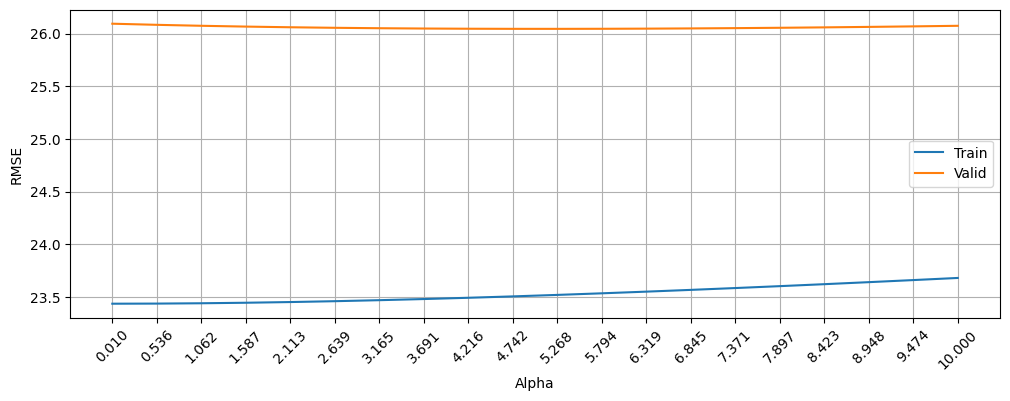

In [31]:
# Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
# Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
valid_scores = []
for alpha in alpha_list:
    # Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr = linear_model.Ridge(alpha=alpha, max_iter=10000)
    # Обучаем модель предсказывать логарифм целевого признака
    ridge_lr.fit(pca_x_train, y_train)
    # Делаем предсказание для каждой из выборок
    y_train_predict = ridge_lr.predict(pca_x_train)
    y_valid_predict = ridge_lr.predict(pca_x_valid)
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.root_mean_squared_error(y_train, y_train_predict))
    valid_scores.append(metrics.root_mean_squared_error(y_valid, y_valid_predict))
 
# Визуализируем изменение RMSE в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(alpha_list, train_scores, label='Train') # График для тренировочной выборки
ax.plot(alpha_list, valid_scores, label='Valid') # График для валидационной выборки
ax.set_xlabel('Alpha') 
ax.set_ylabel('RMSE') 
ax.set_xticks(alpha_list)
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
plt.grid();

Судя по графику минимальный *RMSE* для валидационной выборки достигается при $\alpha = 4.742$. Для тренировочной выборки чем меньше $\alpha$, тем меньше *RMSE*. Жертвуем смещением в пользу уменьшения разброса и останавливаемся на $\alpha = 4.742$.

In [32]:
ridge_lr = linear_model.Ridge(alpha=0.472, max_iter=10000)
ridge_lr.fit(pca_x_train, y_train)
y_train_predict = ridge_lr.predict(pca_x_train)
y_valid_predict = ridge_lr.predict(pca_x_valid)
print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

Train RMSE: 23.437
Valid RMSE: 26.084


На десятые единицы, но улучшить получилось! Теперь *RMSE* для валидационной выборки $26.084$! И это финал моих идей, что можно ещё сделать с данными, дабы улучшить результат.

Тестовая выборка была дана отдельным файлом, причём признак `'SMILES'`, без таргета. Сделаем предсказание значений, но поскольку эталонных ответов нет, рассчитать метрики и оценить их не получится.

In [33]:
test = pd.read_csv("data/test_only_smiles.csv")

In [34]:
# Избавимся от лишнего столбца с индексами
test = test[['SMILES']]
test

,SMILES
0,CC(O)CCO
1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,C=CC(=O)NCNC(=O)C=C
4,CC1=CC(=CC=C1)[N+]([O-])=O
...,...
248,OC(=O)/C=C/C1=CC=CC=C1
249,CCOC(=O)C(C)OC(=O)C1=C(C=CC(OC2=C(Cl)C=C(C=C2)...
250,CCO[Si](CCCNC(N)=O)(OCC)OCC
251,ON=C1CCCCC1


In [35]:
x_test = smiles_to_fp(test.SMILES)

[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerator
[19:32:43] DEPRECATION WARNING: please use MorganGenerat

In [36]:
# Итоговаяя модель
pca = PCA(n_components=127, random_state=42)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_valid= pca.transform(x_valid)
pca_x_test = pca.transform(x_test)

ridge_lr = linear_model.Ridge(alpha=0.472, max_iter=10000)
ridge_lr.fit(pca_x_train, y_train)
y_train_predict = ridge_lr.predict(pca_x_train)
y_valid_predict = ridge_lr.predict(pca_x_valid)
y_test_predict = ridge_lr.predict(pca_x_test)
print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))
# Test RMSE рассчитать не можем

Train RMSE: 23.437
Valid RMSE: 26.084


In [37]:
# Но можем посмотреть предсказания
y_test_predict

array([ 12.93168229,  66.77386863,  86.84774932,   7.09798189,
        61.1095215 ,  33.562872  ,  48.27740145,  13.17074073,
        13.42455707,  15.92410118,  33.37918138,  83.38262521,
        24.17377409,   3.65684891,  66.60187967,  66.82939586,
         7.39912693,  56.84940864,   8.13434871,   1.95566381,
        72.28011152,  21.69084614,  23.53264325, -10.04821981,
        15.07010444,  20.87287882,  83.86509185,  30.84308229,
         6.51446341,   9.3252776 ,  64.61418117,  23.24063273,
        17.09507106,  35.07899581,  47.74057391,  67.29100885,
        20.6256184 ,  60.13532978,  46.39448786,   8.01885134,
        30.68246725,  19.76957429,  57.14635898,  23.16985963,
        37.04866006,  38.43451386,  56.13944763,  44.88381886,
        30.65665518,  28.86199175,  70.06946564,  41.52845795,
        53.48676662,  35.85282993,  63.70715836,  26.90415338,
        -1.15512334,  30.00421458,  74.41910349,  31.38248414,
       102.4850052 ,  22.65048905,  20.285516  ,  34.53